## 합성곱 신경망 맛보기

### 심층 신경망 

**라이브러리 호출**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

**cpu gpu 여부 확인**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**데이터셋 내려받기**

In [ ]:
train_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



**데이터를 데이터로더에 전달**

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100) #데이터를 100개 단위로 묶어서 불러옴

**분류에 사용될 클래스 정의**

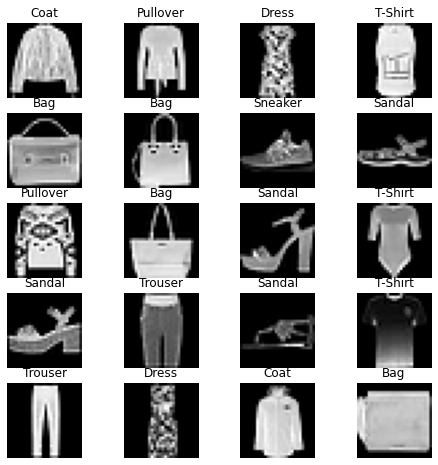

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'} #10개의 클래스

fig = plt.figure(figsize=(8,8)); #출력할 이미지의 가로세로 길이
columns = 4;
rows = 5;
for i in range(1, columns*rows +1): 
    img_xy = np.random.randint(len(train_dataset)); #무작위 표본을 추출할 때 사용
    img = train_dataset[img_xy][0][0,:,:] #3차원 배열 생성
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show() #20개의 이미지 표현

**심층 신경망 모델 생성**

In [ ]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=784,out_features=256) #input size 784, output size 256
        self.drop = nn.Dropout2d(0.25)  # dropout 진행, 0.25만큼의 비율
        self.fc2 = nn.Linear(in_features=256,out_features=128) 
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    def forward(self,input_data): #모델이 forward propagation 진행
        out = input_data.view(-1, 784) #numpy의 reshape과 같은 기능, input data를 (?,784)의 2차원 텐서로 변환
        out = F.relu(self.fc1(out)) #활성화 함수(relu) 지정
        out = self.drop(out) 
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
learning_rate = 0.001; #학습률(lr)
model = FashionDNN(); #모델 지정
model.to(device) 

criterion = nn.CrossEntropyLoss(); #classification 문제에서 사용하는 손실 함수(loss function)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate); #경사하강법으로 adam 사용
print(model) #모델 구조 출력

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


**심층 신경망을 이용한 모델 학습**

In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader: #레코드에서 요소 2개를 가져옴
        images, labels = images.to(device), labels.to(device) #cpu/gpu 통일
    
        train = Variable(images.view(100, 1, 28, 28))  #Variable을 이용해 역전파를 위한 미분값 자동으로 계산
        labels = Variable(labels)
        
        outputs = model(train) #학습 데이터를 모델에 적용
        loss = criterion(outputs, labels) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):  #count를 50으로 나눴을 때 0이 아니면 실행
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total #정확도 예측
            loss_list.append(loss.data) #append를 이용해 리스트에 데이터를 하나씩 추가
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500): #count를 500으로 나눴을 때 0이 아니면 print로 결과를 보여줌
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5497425198554993, Accuracy: 83.3499984741211%
Iteration: 1000, Loss: 0.48211437463760376, Accuracy: 84.30999755859375%
Iteration: 1500, Loss: 0.3537752628326416, Accuracy: 84.63999938964844%
Iteration: 2000, Loss: 0.35956668853759766, Accuracy: 85.33999633789062%
Iteration: 2500, Loss: 0.25863322615623474, Accuracy: 86.63999938964844%
Iteration: 3000, Loss: 0.28179723024368286, Accuracy: 86.6500015258789%


### 합성곱 네트워크 생성

In [ ]:
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()        
        self.layer1 = nn.Sequential( #첫번째 레이어
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), #합성곱층(conv layer)
            nn.BatchNorm2d(32), #batch normalization
            nn.ReLU(), #ReLU 활성화함수
            nn.MaxPool2d(kernel_size=2, stride=2) #max pooling layer
        )       
        self.layer2 = nn.Sequential( #두번째 레이어
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) #공식을 이용해 1차원으로 변경
        self.drop = nn.Dropout2d(0.25) #dropout(위랑 똑같음)
        self.fc2 = nn.Linear(in_features=600, out_features=120) #fc layer
        self.fc3 = nn.Linear(in_features=120, out_features=10) #마지막 out은 클래스의 개수를 의미함
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #합성곱층에서 fc layer로 연결되는 부분이기 때문에 1차원으로 바꿔줌
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)       
        return out

In [ ]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.4876278340816498, Accuracy: 87.18000030517578%
Iteration: 1000, Loss: 0.35017630457878113, Accuracy: 87.12999725341797%
Iteration: 1500, Loss: 0.28021568059921265, Accuracy: 88.69999694824219%
Iteration: 2000, Loss: 0.19052854180335999, Accuracy: 89.6199951171875%
Iteration: 2500, Loss: 0.14415787160396576, Accuracy: 89.94999694824219%
Iteration: 3000, Loss: 0.20658329129219055, Accuracy: 89.43000030517578%


정확도가 조금 더 높아진 것을 확인할 수 있다!

## 특성 추출 기법

**라이브러리 호출**

In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

**데이터 로컬에 다운받으신 분은 바로 아래 코드로 하시면 됩니다**

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

In [ ]:
!unzip catanddog.zip -d catanddog/    #catanddog 폴더 만들어 압축 풀기

Archive:  catanddog.zip
  inflating: catanddog/train/Cat/0.jpg  
  inflating: catanddog/train/Cat/1.jpg  
  inflating: catanddog/train/Cat/10.jpg  
  inflating: catanddog/train/Cat/11.jpg  
  inflating: catanddog/train/Cat/12.jpg  
  inflating: catanddog/train/Cat/13.jpg  
  inflating: catanddog/train/Cat/14.jpg  
  inflating: catanddog/train/Cat/15.jpg  
  inflating: catanddog/train/Cat/16.jpg  
  inflating: catanddog/train/Cat/17.jpg  
  inflating: catanddog/train/Cat/18.jpg  
  inflating: catanddog/train/Cat/19.jpg  
  inflating: catanddog/train/Cat/2.jpg  
  inflating: catanddog/train/Cat/20.jpg  
  inflating: catanddog/train/Cat/21.jpg  
  inflating: catanddog/train/Cat/22.jpg  
  inflating: catanddog/train/Cat/23.jpg  
  inflating: catanddog/train/Cat/24.jpg  
  inflating: catanddog/train/Cat/25.jpg  
  inflating: catanddog/train/Cat/26.jpg  
  inflating: catanddog/train/Cat/27.jpg  
  inflating: catanddog/train/Cat/28.jpg  
  inflating: catanddog/train/Cat/29.jpg  
  inflating: 

**구글 드라이브에 있으신 분들은 마운트**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pwd

/content


**데이터 전처리 방법 정의**

In [ ]:
data_path = "./drive/My Drive/sorce/chap05/data/catanddog/train/"
#local에 했을 경우 
#data_path = '/catanddog/train/' 이나 자기가 파일 위치한 곳으로 바꾸기
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]), #이미지 크기 조정
                    transforms.RandomResizedCrop(224), #이미지 랜덤한 비율로 자른 후 크기 조정,데이터 확장 용도
                    transforms.RandomHorizontalFlip(), #이미지를 랜덤하게 수평으로 뒤집음
                    transforms.ToTensor(), #텐서로 변환
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32, #한 번에 불러올 데이터양
    num_workers=8, #하위 프로세스 개수
    shuffle=True #무작위로 섞을 것인지 결정
)

print(len(train_dataset)) #데이터의 개수 출력

385


**데이터 미리보기**

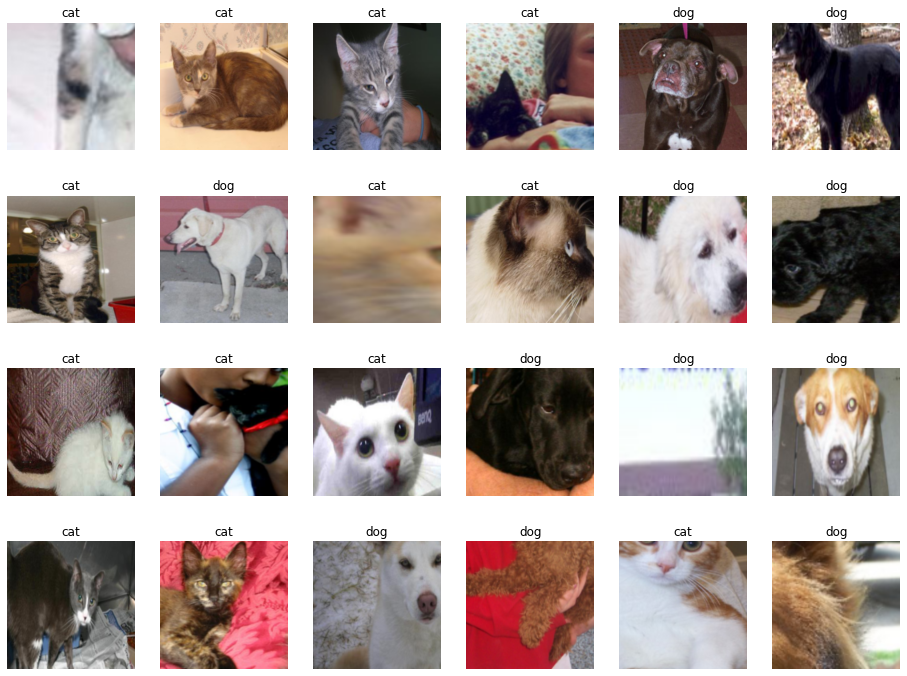

In [ ]:
import numpy as np
#samples, labels = iter(train_loader).next() 오류나시는 분은 바로 밑에 걸로 실행~ pytorch 버전 문제인듯해용
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

**사전 훈련된 모델 내려받기**

In [ ]:
resnet18 = models.resnet18(pretrained=True) #ResNet18 모델

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**사전 훈련된 모델의 파라미터 학습 유무 지정**

In [ ]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 역전파 중 파라미터에 대한 변화 계산할 필요 x (모델의 일부 고정)
            
set_parameter_requires_grad(resnet18)

**ResNet18에 FC layer 추가**

In [ ]:
resnet18.fc = nn.Linear(512, 2) #2는 클래스가 2개라는 뜻(cat 아니면 dog)

**모델의 파라미터 값 확인**

In [ ]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0375,  0.0057,  0.0145,  ..., -0.0073, -0.0414, -0.0175],
        [ 0.0427,  0.0148,  0.0182,  ..., -0.0146, -0.0393, -0.0294]])
fc.bias tensor([-0.0392, -0.0001])


**모델 객체 생성 및 손실함수 정의**

In [ ]:
model = models.resnet18(pretrained = True) #모델 객체 생성

for param in model.parameters(): #conv layer 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): #fc layer는 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() #손실함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**모델 학습을 위한 함수 생성**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time() #컴퓨터의 현재 시각을 구하는 함수 
    acc_history = [] 
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs): #에포크만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders: #데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad() #기울기 0으로 초기화
            outputs = model(inputs) #순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset) #평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) #평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join("./drive/My Drive/sorce/chap05/data/catanddog/", '{0:0=2d}.pth'.format(epoch))) #모델 재사용을 위해 저장해둠
        print()

    time_elapsed = time.time() - since #실행 시간을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history #모델 정확도와 오차를 반환

**파라미터 학습 결과를 옵티마이저에 저장**

In [ ]:
params_to_update = [] 
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) #파라미터 학습 결과 저장
        print("\t",name)
            
optimizer = optim.Adam(params_to_update) #학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


**모델 학습**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.4269 Acc: 0.8208

Epoch 1/12
----------
Loss: 0.3737 Acc: 0.8286

Epoch 2/12
----------
Loss: 0.2843 Acc: 0.9143

Epoch 3/12
----------
Loss: 0.2748 Acc: 0.8961

Epoch 4/12
----------
Loss: 0.2238 Acc: 0.9091

Epoch 5/12
----------
Loss: 0.2108 Acc: 0.9273

Epoch 6/12
----------
Loss: 0.2367 Acc: 0.8987

Epoch 7/12
----------
Loss: 0.2013 Acc: 0.9351

Epoch 8/12
----------
Loss: 0.2011 Acc: 0.9299

Epoch 9/12
----------
Loss: 0.1751 Acc: 0.9273

Epoch 10/12
----------
Loss: 0.2239 Acc: 0.9143

Epoch 11/12
----------
Loss: 0.1831 Acc: 0.9325

Epoch 12/12
----------
Loss: 0.2384 Acc: 0.8987

Training complete in 0m 45s
Best Acc: 0.935065


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**테스트 데이터 호출 및 전처리**

In [ ]:
test_path = "./drive/My Drive/sorce/chap05/data/catanddog/test"

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


**테스트 데이터 평가 함수 생성**

In [ ]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob("./drive/My Drive/sorce/chap05/data/catanddog/" + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

**테스트 데이터를 평가 함수에 적용**

In [ ]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./drive/My Drive/sorce/chap05/data/catanddog/00.pth', './drive/My Drive/sorce/chap05/data/catanddog/01.pth', './drive/My Drive/sorce/chap05/data/catanddog/02.pth', './drive/My Drive/sorce/chap05/data/catanddog/03.pth', './drive/My Drive/sorce/chap05/data/catanddog/04.pth', './drive/My Drive/sorce/chap05/data/catanddog/05.pth', './drive/My Drive/sorce/chap05/data/catanddog/06.pth', './drive/My Drive/sorce/chap05/data/catanddog/07.pth', './drive/My Drive/sorce/chap05/data/catanddog/08.pth', './drive/My Drive/sorce/chap05/data/catanddog/09.pth', './drive/My Drive/sorce/chap05/data/catanddog/10.pth', './drive/My Drive/sorce/chap05/data/catanddog/11.pth', './drive/My Drive/sorce/chap05/data/catanddog/12.pth']
Loading model ./drive/My Drive/sorce/chap05/data/catanddog/00.pth
Acc: 0.8878

Loading model ./drive/My Drive/sorce/chap05/data/catanddog/01.pth
Acc: 0.9082

Loading model ./drive/My Drive/sorce/chap05/data/catanddog/02.pth
Acc: 0.9184

Loading model ./drive/My Drive/sorc

**정확도 그래프로 확인**

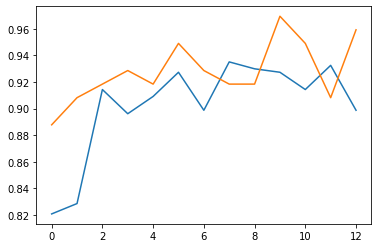

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

**train 데이터 오차 그래프로 확인**

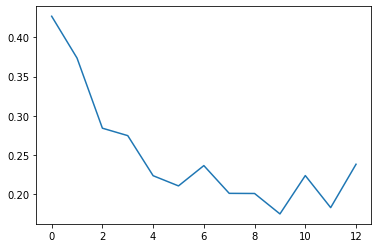

In [ ]:
plt.plot(train_loss_hist)
plt.show()

**예측 이미지를 출력하기 위한 전처리 함수**

In [ ]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

**예측 결과**

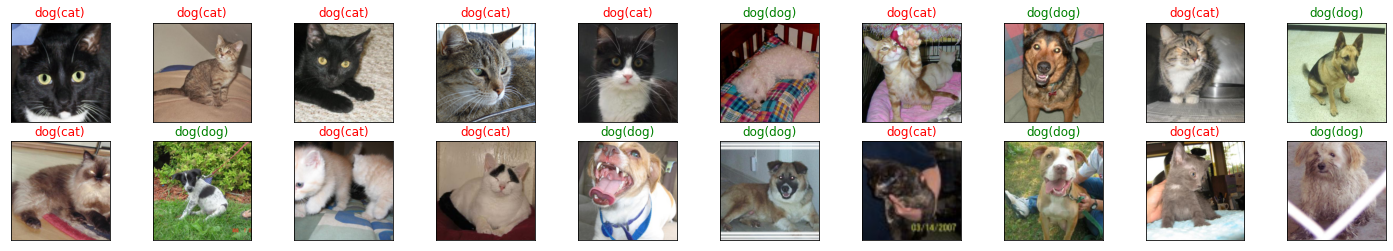

<Figure size 432x288 with 0 Axes>

In [ ]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  
#images,labels=dataiter.next() 
images, labels = next(dataiter)
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

빨간색은 잘못 예측된 것, 초록색은 잘 예측된 것

## 설명 가능한 시각화

**특성 맵 시각화**

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**설명 가능한 네트워크 생성**

In [ ]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), #기존의 데이터를 연산의 결괏값으로 대체하는 것을 의미
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

**모델 객체화**

In [ ]:
model=XAI()
model.cpu() #모델에 입력되는 이미지를 넘파이로 받아오는 부분때문에 CPU를 사용하도록 지정하였습니다
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

**특성 맵을 확인하기 위한 클래스 정의**

In [ ]:
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
   
    def hook_fn(self, module, input, output):
        output = output
        #self.features = output.to(device).detach().numpy()
        self.features = output.detach().numpy()
    def remove(self): 
        self.hook.remove()

**이미지 호출**

Saving cat.jpg to cat.jpg
torch.Size([1, 3, 100, 100])


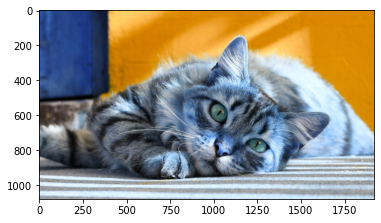

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap05/data/cat.jpg 데이터 불러오기

img=cv2.imread("cat.jpg")   
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)

print(img.shape)

**Conv 2d 특성 맵 확인**

In [ ]:
result = LayerActivations(model.features, 0)
model(img)
activations = result.features

<ipython-input-2-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


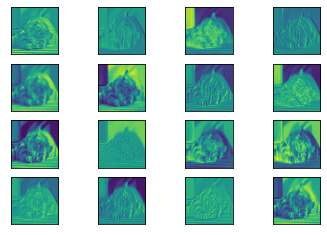

<Figure size 864x576 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

**20번째 계층에 대한 특성 맵**

In [ ]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

<ipython-input-2-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


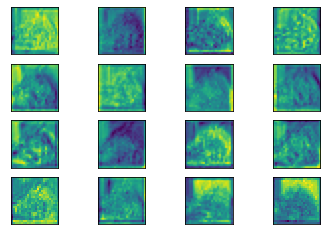

<Figure size 864x576 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

**40번째 계층에 대한 특성 맵**

In [ ]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

<ipython-input-2-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


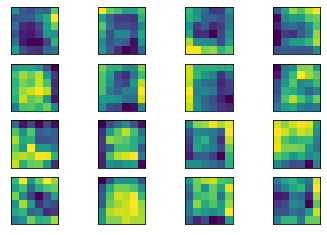

<Figure size 864x576 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()